# Costa Rica Pipeline Notebook
## {Insert info on notebook purpose}

### Project objective:
- {TODO}

#### Notebook sections:
1. Setup
2. Data Acquisition / Cleaning
3. Utilizing ML Models
4. Maps / Visualizations / Documentation

#### Data sources
- {TODO}

## Section 1 - Setup

### Section 1.1 - Installing software and importing packages

In [188]:
!pip install pandas numpy geopandas seaborn scikit-learn tensor folium matplotlib mapclassify earthengine-api geemap


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [189]:
from geopandas import GeoDataFrame
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd
import numpy as np
import pprint
import geemap
import ee
import folium
import matplotlib.pyplot as plt

### Section 1.2 - Importing our Dataset

In [190]:
# We are importing the observational data from the ZIP file provided (which contains the shape file) into a GeoDataFrame
gdf = gpd.read_file('../Costa Rican Data/Classification_Plots.zip')

# These display information about the GeoDataFrame to confirm the contains are what we expected
display(gdf.crs)
display(gdf.columns)

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Index(['Source.Nam', 'plotid', 'sampleid', 'lon', 'lat', 'sample_geo', 'Uso',
       'Cobertura', 'Vegetacion', 'Herbaceas', 'Pasto_Arb', 'Cultivo',
       'Humedal', 'Terreno', 'Agua', 'Otra_clase', 'SAF', 'Cambios15_',
       'Gana_Perdi', 'geometry'],
      dtype='object')

### Section 1.3 - English Translations

Renaming every column name to their respective English translation

In [191]:
# Insert code here for Section 1.3
k_clms = ['plotid','sampleid','Uso','Cobertura','Vegetacion','Herbaceas', 'Pasto_Arb', 'Cultivo','Humedal', 'Terreno','Agua','Otra_clase','SAF','Cambios15_','Gana_Perdi','geometry']
gdf_s=gdf[k_clms]
# gdf_s


# new column names
english_translations_predictors = {
    'Uso': 'Use',
    'Cobertura': 'CoverType',
    'Vegetacion': 'Vegetations',
    'Herbaceas': 'Herbaceous',
    'Pasto_Arb': 'GrasslandShrub',
    'Cultivo': 'CropsType',
    'Humedal': 'WetlandArea',
    'Terreno': 'LandType',
    'Agua': 'WaterBodyType',
    'Otra_clase': 'OtherClass',
    'SAF': 'SAF',
    'Cambios15_': 'Changes_15',
    'Gana_Perdi': 'Gain_Loss',
}

# Create a new GeoDataFrame with selected columns and translations
gdf_e = gdf[k_clms].copy()  # Creating a new GeoDataFrame
gdf_e.rename(columns=english_translations_predictors, inplace=True)  # Renaming columns

Renaming each predictor according to their respective English translation

In [192]:
# Translation dictionaries for each categorical predictor
translation_dicts = {
    'Use': { # num of missing values: 216
        'Bosque': 'Forest',
        'Pastos': 'Grasslands',
        'Humedal': 'Wetlands',
        'Otras clases': 'Other classes',
        'Agricultura': 'Agriculture',
        'Plantacion forestal': 'Forest plantation',
        'Sin informacion': 'No information',
        'None': 'None'
    },
    'CoverType': { # num of missing values: 216
        'Vegetacion': 'Vegetation',
        'Sin vegetacion': 'No vegetation',
        'Agua': 'Water',
        'Sin informacion': 'No information',
        'Nubes y sombras': 'Clouds and shadows',
        'None': 'None'
    },
     'Changes_15': {# num of missing values: 216
        'No se determina': 'Not determined',
        'No': 'No',
        'Si': 'Yes',
        'None': 'None'
    },
    'Vegetations': {
        'Arboles': 'Trees',
        'Herbaceas': 'Herbaceous plants',
        'None': 'None',
        'Palmas': 'Palms',
        'Arbustos': 'Shrubs',
        'Otra vegetacion': 'Other vegetation',
        'Saran': 'Saran (plastic cover)',
        'Plastico': 'Plastic'
    },
    'Herbaceous': {
        'None': 'None',
        'Gramineas': 'Grasses',
        'Otras Herbaceas': 'Other Herbaceous',
        'Musaceas': 'Plantains'
    },
    'GrasslandShrub': {
        'None': 'None',
        'Pastos mezclados (70-90%)': 'Mixed Pasture (70-90%)',
        'Pastos Puros (90-100%)': 'Pure Pasture (90-100%)',
        'Pastos Combinados (50-70%)': 'Combined Pasture (50-70%)'
    },
    'CropsType': { # 10 different crop types
        'None': 'None',
        'Pina': 'Pineapple',
        'Otro': 'Other',
        'Arroz': 'Rice',
        'Citricos': 'Citrus',
        'Cana': 'Sugarcane',
        'Palma': 'Palm',
        'Banano': 'Banana',
        'Melon': 'Melon',
        'Sandia': 'Watermelon',
        'Cafe': 'Coffee'
    },
     'WaterBodyType': { # 2 types of water bodies
        'None': 'None',
        'Continentales': 'Continental',
        'Mar�timas': 'Marine'
    },

    'WetlandArea': { # 5 wetland area types
        'None': 'None',
        'Pantano (Palustre)': 'Swamp (Marsh)',
        'Cuerpos de agua': 'Water bodies',
        'Yolillal': 'Yolillal_Plants',
        'Salinera': 'Salt marsh',
        'Manglar': 'Mangrove'
    },
    'LandType': {
        'None': 'None',
        'Otras superficies': 'Other surfaces', # forested areas?
        'Terreno descubierto': 'Exposed land', #  land degradation (soil is exposed)
        'Suelo desnudo': 'Bare Land' # lacks cover (deforestation, desert)
    },
    'OtherClass': {
        'None': 'None',
        'Edificado / Desarrollado': 'Built/Developed',
        'Suelo desnudo': 'Bare Land',
        'Nubes': 'Clouds',
        'Sombra de nubes': 'Cloud shadow',
        'Paramo': 'Páramo (high-altitude ecosystem)',
        'Playas y arenales': 'Beaches and sandbanks'
    },
    'SAF': {
        'None': 'None',
        'Cultivo Puro (90-100%)': 'Pure crop (90-100%)',
        'Cultivo mezclado (70-90%)': 'Mixed crop (70-90%)',
        'Cultivo Combinado (50-70%)': 'Combined crop (50-70%)'
    },
    'Gain_Loss': {
        'None': 'None',# third category no gain or loss
        'Perdida de Bosque': 'Forest loss',
        'Ganancia de Bosque': 'Forest gain'
    }
}

# Loop through each column and replace the Spanish values with the English translations
for col, trans_dict in translation_dicts.items():
    gdf_e[col] = gdf_e[col].replace(trans_dict)

Confirming the translations in the new Dataframe

In [193]:
# set display options to show more content
pd.set_option('display.max_colwidth', None)  # Allows full width of content in each column
pd.set_option('display.max_rows', None)      # Show all rows (if there are not too many unique values)

# Now, get and display unique values for each categorical feature
unique_values = gdf_e.select_dtypes(include=['object', 'category']).apply(lambda x: x.unique())

# Display the result
print(unique_values)

Use                             [Forest, Grasslands, Wetlands, Other classes, Agriculture, Forest plantation, No information, None]
CoverType                                              [Vegetation, No vegetation, Water, No information, Clouds and shadows, None]
Vegetations                       [Trees, Herbaceous plants, None, Palms, Shrubs, Other vegetation, Saran (plastic cover), Plastic]
Herbaceous                                                                             [None, Grasses, Other Herbaceous, Plantains]
GrasslandShrub                                    [None, Mixed Pasture (70-90%), Pure Pasture (90-100%), Combined Pasture (50-70%)]
CropsType                                [None, Pineapple, Other, Rice, Citrus, Sugarcane, Palm, Banana, Melon, Watermelon, Coffee]
WetlandArea                                              [None, Swamp (Marsh), Water bodies, Yolillal_Plants, Salt marsh, Mangrove]
LandType                                                                    

New translated gdf is named
∴ `gdf_e`

## Section 2 - Data Acquisition and Cleaning

### Section 2.1 - Points imported, and points turned into "wide" format for the "9->1 row per plot conversion

In [194]:
# Insert code here for Section 2.1

### Section 2.2 - Exploratory Data Analysis (EDA)

#### Section 2.2.1 Exploration of Plots and Points

In [195]:
# Count of points, count of plots, and ID of NA's (if appropriate).

# Reworked solution - Convert columns to objects and get those statistics instead of the numerical ones
plotid_obj_stats = (gdf_s['plotid'].astype('object')).describe()
sampleid_obj_stats = (gdf_s['sampleid'].astype('object')).describe()

# Combine above results into a single dataframe
results_df = pd.concat([plotid_obj_stats, sampleid_obj_stats], axis=1)

# Check for NAs in each column and append to dataframe
results_df.loc["Has NAs"] = [str(gdf_s['plotid'].isna().any()), str(gdf_s['sampleid'].isna().any())]

# Display results
display(results_df)

,plotid,sampleid
count,101160,101160
unique,11233,49469
top,2175,12417
freq,18,4
Has NAs,False,False


In summary, out of the **101,160 rows of data** in our Dataframe, there are only:
- 11,233 unique plots,
- 49,469 unique sampleids (points).

However, you can notice that the highest frequency for sampleids is more than 1, which means there are sampleids being used more than once.

> Question 1: How many sampleids (points) are being used more than one time?

Also, there are no NA values in these two columns.

In [196]:
# Count of plots that have fewer than 9 points per plot (and why)

# Create subsets of gdf_s where the frequency of the plotid/sampleid is calculated
plotid_counts = pd.DataFrame(gdf_s['plotid'].value_counts(dropna=False))
sampleid_counts = pd.DataFrame(gdf_s['sampleid'].value_counts(dropna=False))

# Creates subsets of sampleid_counts that counts the frequency of each points' frequency
sampleid_counts_mt0 = sampleid_counts[sampleid_counts['count'] > 0]
sampleid_counts_frequency = pd.DataFrame(sampleid_counts_mt0['count'].value_counts())
sampleid_counts_frequency.rename(columns={ sampleid_counts_frequency.columns[0]: "count frequency" }, inplace=True)

print("There are {number_of_rows} plotid's with less than 9 points per plot:".format(number_of_rows=len(plotid_counts[plotid_counts['count'] < 9])))
display(plotid_counts[plotid_counts['count'] < 9])

print("There are {number_of_rows} plotid's with more than 9 points per plot:".format(number_of_rows=len(plotid_counts[plotid_counts['count'] > 9])))
display(plotid_counts[plotid_counts['count'] > 9])

# This answers Question 1: "How many sampleids (points) are being used more than one time?"
print("There are {number_of_rows} points that appear more than once:".format(number_of_rows=len(sampleid_counts[sampleid_counts['count'] > 1])))
display(sampleid_counts_frequency)

There are 0 plotid's with less than 9 points per plot:


,count
plotid,


There are 7 plotid's with more than 9 points per plot:


,count
plotid,
2175,18
4607,18
6916,18
3150,18
3105,18
3163,18
1630,18


There are 41437 points that appear more than once:


,count frequency
count,
2,31204
3,10212
1,8032
4,21


In summary, out of all the unique plots in our data:
- **None** have less than nine points per plot
- **Seven** have more than nine points per plot (exactly 18 in fact)

> Question 2: Why do those seven plots have 18 points instead of nine?

> Question 3: Are all 18 of those points unique, or are some of them repeated?

##### **Recall Question 1: "How many sampleids (points) are being used more than one time?"**

Out of all the sampleids (points) in our data:
- **21** appear four times
- **10,212** three times
- **31,204** appear two times
- **8,032** appear one time

> Question 4: Are there sampleids that are associated with **more than one** unique geometric point?

In [197]:
# This answers Question 2: "Why do those seven plots have 18 points instead of nine?"
# Also Question 3: "Are all 18 of those points unique, or are some of them repeated?"

"""
This function groups a DataFrame by `id_name`, checks if the `associated_id` values in each group are unique, and returns:
1) A DataFrame with all groups and their uniqueness status.
2) A filtered DataFrame showing only groups with duplicate `associated_id` values.
"""
def analyze_ids(df, id_name, associated_id):
    # TODO: Finish redoing of function
    # Filter 'sampleid' values where 'geometry' equals a specific value
    result = df.groupby(id_name)[associated_id].apply(list)

    # Create a new DataFrame from the result
    result_df = result.reset_index(name=(associated_id + "_list"))

    # Add a column to check if all sampleid values are unique
    result_df['all_unique'] = result_df[associated_id + "_list"].apply(lambda x: len(x) == len(set(x)))

    # Filter rows where all_unique == False
    duplicated_rows = result_df[result_df['all_unique'] == False].copy()

    # Adjust the sampleid_list column to show only duplicated values
    duplicated_rows['duplicated_' + associated_id] = duplicated_rows[associated_id + "_list"].apply(
        lambda x: [item for item in set(x) if x.count(item) > 1]
    )

    return result_df, duplicated_rows[[id_name, 'duplicated_' + associated_id]]

# Use the defined function above to check which sampleids are associated with which plotid
results_df, duplicates_df = analyze_ids(gdf_s, "plotid", "sampleid")

# Display the results
display(results_df[results_df['all_unique'] == False])
display(duplicates_df)

,plotid,sampleid_list,all_unique
1610,1630,"[6517, 6517, 6518, 6518, 6519, 6519, 6520, 6520, 6521, 6521, 6522, 6522, 6523, 6523, 6524, 6524, 6525, 6525]",False
2153,2175,"[8697, 8697, 8698, 8698, 8699, 8699, 8700, 8700, 8701, 8701, 8702, 8702, 8703, 8703, 8704, 8704, 8705, 8705]",False
3082,3105,"[12417, 12417, 12418, 12418, 12419, 12419, 12420, 12420, 12421, 12421, 12422, 12422, 12423, 12423, 12424, 12424, 12425, 12425]",False
3127,3150,"[12597, 12597, 12598, 12598, 12599, 12599, 12600, 12600, 12601, 12601, 12602, 12602, 12603, 12603, 12604, 12604, 12605, 12605]",False
3140,3163,"[12649, 12649, 12650, 12650, 12651, 12651, 12652, 12652, 12653, 12653, 12654, 12654, 12655, 12655, 12656, 12656, 12657, 12657]",False
4584,4607,"[18425, 18425, 18426, 18426, 18427, 18427, 18428, 18428, 18429, 18429, 18430, 18430, 18431, 18431, 18432, 18432, 18433, 18433]",False
6893,6916,"[27661, 27661, 27662, 27662, 27663, 27663, 27664, 27664, 27665, 27665, 27666, 27666, 27667, 27667, 27668, 27668, 27669, 27669]",False


,plotid,duplicated_sampleid
1610,1630,"[6517, 6518, 6519, 6520, 6521, 6522, 6523, 6524, 6525]"
2153,2175,"[8704, 8705, 8697, 8698, 8699, 8700, 8701, 8702, 8703]"
3082,3105,"[12417, 12418, 12419, 12420, 12421, 12422, 12423, 12424, 12425]"
3127,3150,"[12597, 12598, 12599, 12600, 12601, 12602, 12603, 12604, 12605]"
3140,3163,"[12649, 12650, 12651, 12652, 12653, 12654, 12655, 12656, 12657]"
4584,4607,"[18432, 18433, 18425, 18426, 18427, 18428, 18429, 18430, 18431]"
6893,6916,"[27661, 27662, 27663, 27664, 27665, 27666, 27667, 27668, 27669]"


##### **Recall Questions 2 & 3: "Why do those seven plots have 18 points instead of nine; also, are all 18 of those points unique, or are some of them repeated?"**
Visually, we can tell that these seven plots:
- Have had 9 sampleid's counted twice,
- Do not have all associated sampleid's unique.

> Question TODO: In those seven plotids with 18 sampleids, do the duplicated sampleids contain the same information?

In [198]:
# This answers Question 4: "Are there sampleids that are associated with more than one unique geometric point?"

# Call the analyze_ids function to analyze the values of each sampleid and determine if and what the duplicates are
results_df, duplicates_df = analyze_ids(gdf_s, "sampleid", "geometry")

results_mt1_geopoint = results_df[results_df['geometry_list'].apply(len) > 1]

# Display the results of the above function call
display(results_mt1_geopoint[results_mt1_geopoint['all_unique'] == True].head())
display(results_df.shape)
display(results_mt1_geopoint[results_mt1_geopoint['all_unique'] == True].shape[0])
display(results_df[results_df['all_unique'] == False].shape[0])

,sampleid,geometry_list,all_unique
4,9,"[POINT (-85.132333 9.614592000000002), POINT (-85.13269219133643 9.59244283783545)]",True
5,10,"[POINT (-85.132333 9.615017134355497), POINT (-85.13269219133643 9.59286800000001)]",True
6,11,"[POINT (-85.13190180866356 9.614166865110107), POINT (-85.13269219133643 9.593293161631365)]",True
7,12,"[POINT (-85.13190180866356 9.614592000000002), POINT (-85.132261 9.59244283783545)]",True
8,13,"[POINT (-85.13190180866356 9.615017134355497), POINT (-85.132261 9.59286800000001), POINT (-85.11377119133644 9.603370851547993)]",True


(49469, 3)

41374

63

**Recall Question 4: "Are there sampleids that are associated with **more than one** unique geometric point?"**

To answer this, we're going to analyze the `geometric` column, in the `gdf_s` dataframe, for each `sampleid` that appears **more than once**.

> Note: We are using the `geometric` column since it aggregates the longitude and latitude into a single column and data type

Taking a look at the resulting dataframe from our analysis function, we can tell that from the 49,469 unique sampleids:
- 41,374 are associated with **multiple unique** geometric points
- 63 are associated with **some duplicated** geometric points

Therefore, the answer to Question 4 is **Yes**, since 41,374 sampleids are associated with **more than one** unique geometric point.

> Question 5: Are there geometry points that are associated with **more than one** unique sampleid?

In [199]:
# This should answer Question 5: "Are there geometry points that are associated with more than one unique sampleid?"

results_df, duplicates_df = analyze_ids(gdf_s, "geometry", "sampleid")

results_mt1_sampleid = results_df[results_df['sampleid_list'].apply(len) > 1]

# Uncomment to show that there are no geometry points associated with more than two sampleids
#display(results_df[results_df['sampleid_list'].apply(len) > 2])

# Display the results of the above function call
display(results_mt1_sampleid[results_mt1_sampleid['all_unique'] == True].head())
display(results_df.shape)
display(results_mt1_sampleid[results_mt1_sampleid['all_unique'] == True].shape[0])
display(results_df[results_df['all_unique'] == False].shape[0])

,geometry,sampleid_list,all_unique
36,POINT (-84.37434 9.50804),"[227, 3600227]",True
37,POINT (-84.3739 9.50804),"[230, 3600230]",True
38,POINT (-84.3739 9.50762),"[229, 3600229]",True
39,POINT (-84.37434 9.50762),"[226, 3600226]",True
40,POINT (-84.37434 9.50719),"[225, 3600225]",True


(91917, 3)

9180

63

**Recall Question 5: "Are there geometry points that are associated with more than one unique sampleid?"**

With the analysis function used previous, we can aggregate all the sampleids associated with each geometry point.

Taking a look at the resulting table, and its dimensions, we can see that of the 91,917 unique geometry points:
- 9,180 are associated with multiple **unique** sampleids
- 63 are associated with multiple **of the same** sampleids

> Note: We know this because each geometry point is only associated with **up to** two sampleids (shown by the commented code above)

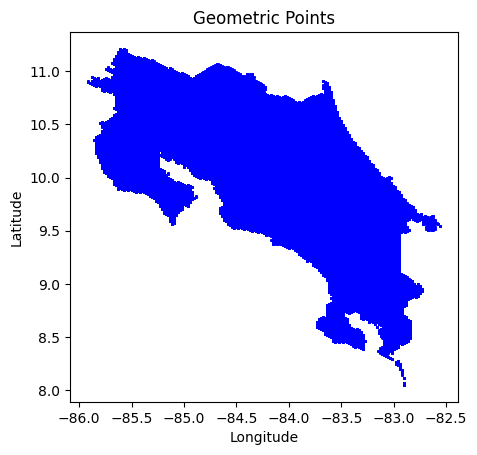

In [200]:
# TODO: Plot the points on the map, not just a normal map
# Map the plots (the 10,000 not the 90,000)
gdf_s.plot(color="blue", markersize=1)
plt.title("Geometric Points")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

### Section 2.3 - Acquisition of data from GEE

## Section 3 - Utilizing ML Models

### Section 3.1 - Feature Selection

In [201]:
# Insert code here for Section 3.1

### Section 3.2 - Model Research

In [202]:
# Insert code here for Section 3.2

### Section 3.3 - Model Comparisons

In [203]:
# Insert code here for Section 3.3

## Section 4 - Maps / Visualizations / Documentation

### Section 4.1 - Creating the maps

In [204]:
# Insert code here for Section 4.1